<br>

<p style="text-align:center; font-weight:bold; font-size:17px;">Realized Volatility & Skew</p>

<p style="text-align:center; font-size:14px;">In this notebook, we want to study and compare two assets' realized volatility accross strikes</p>

<p style="text-align:center; font-size:14px;">We will use numerical optimization to determine the realized volatility</p>

In [1]:
# -----
# IMPORT PUBLIC LIBRAIRIES
# -----
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn import linear_model
import plotly.graph_objects as go
from scipy.optimize import minimize_scalar
from sklearn.preprocessing import PolynomialFeatures

# -----
# IMPORT PRIVATE LIBRAIRIES
# -----
from module.backtest import black_scholes_delta_hedged

# -----
# SET DISPLAY SETTINGS
# -----
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [2]:
# -----
# GLOBAL INPUT
# -----
file_path = 'data/'
asset_list = ['SPY', 'IWM']

# -----
# IMPORT DATA
# -----
file_path_asset1 = file_path + asset_list[0] + ".csv"
file_path_asset2 = file_path + asset_list[1] + ".csv"
close_price_asset1_pd = pd.read_csv(file_path_asset1, index_col=0, parse_dates=True)['Adj Close']
close_price_asset2_pd = pd.read_csv(file_path_asset2, index_col=0, parse_dates=True)['Adj Close']

# -----
# RESHAPE DATA
# -----
common_index = sorted(set(close_price_asset1_pd.index).intersection(close_price_asset2_pd.index))
close_price_asset1_pd = close_price_asset1_pd.loc[common_index]
close_price_asset2_pd = close_price_asset2_pd.loc[common_index]

<br>

<p style="text-align:center; font-weight:bold; font-size:15px;">Numerical Optimization Method</p>

In [3]:
# -----
# DEFINE OBJECTIVE FUNCTION
# -----
def objective_function(x, close_price_dict, option_type, strike, maturity, roll_day):
    bt_df = black_scholes_delta_hedged(close_price_dict, option_type, strike, maturity, roll_day,  sigma=x)
    return bt_df.iloc[-1]['CumOptionHedgedPnL']**2

# -----
# SET CLOSE PRICE TIMESERIES
# -----
close_price_asset1_pd = close_price_asset1_pd.iloc[-250:]
close_price_asset2_pd = close_price_asset2_pd.iloc[-250:]
close_price_asset1_dict = close_price_asset1_pd.to_dict()
close_price_asset2_dict = close_price_asset2_pd.to_dict()

# -----
# DEFINE OPTION PARAMETER
# -----
option_type = 'call'
maturity = 20
roll_day = 0
k1 = 0.90
k2 = 1.1

# -----
# SOLVE IMPLIED VOLATILITY X STRIKE
# -----
skew_results_dict = dict()
for strike in tqdm(np.linspace(start=k1, stop=k2, num=100)):
    res_asset1 = minimize_scalar(objective_function, method='bounded', bounds=(0.03, 10), args=(close_price_asset1_dict, option_type, strike, maturity, roll_day))
    res_asset2 = minimize_scalar(objective_function, method='bounded', bounds=(0.03, 10), args=(close_price_asset2_dict, option_type, strike, maturity, roll_day))
    skew_results_dict[strike] = [res_asset1.x, res_asset2.x]
skew_results_df = pd.DataFrame(skew_results_dict).transpose()
skew_results_df.columns = asset_list

  0%|          | 0/100 [00:00<?, ?it/s]

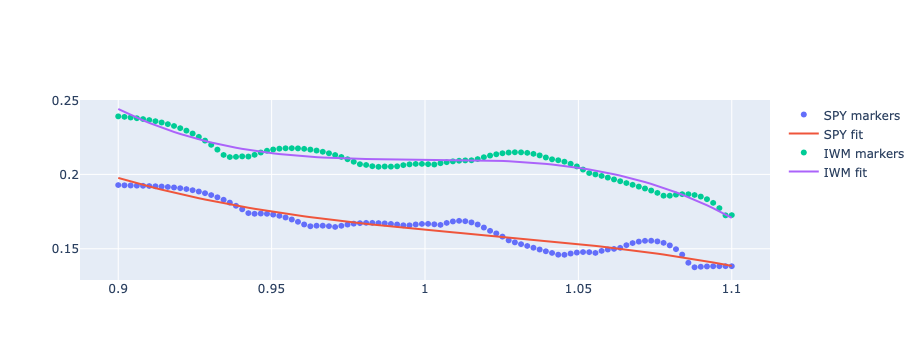

In [4]:
# -----
# MODELS VOLATILITY SURFACE AND PLOT
# -----
fig = go.Figure()
for asset in asset_list:

    reg = linear_model.LinearRegression()
    poly = PolynomialFeatures(3)
    X = skew_results_df[asset].reset_index().iloc[:, [0]].to_numpy()
    X = poly.fit_transform(X)
    y = skew_results_df[asset].to_numpy()
    reg.fit(X, y)
    y_pred = reg.predict(X)
    skew_results_df.loc[:, f"{asset} fit"] = y_pred

    fig.add_trace(go.Scatter(x=skew_results_df.index, y=skew_results_df[asset], mode='markers', name=f"{asset} markers"))
    fig.add_trace(go.Scatter(x=skew_results_df.index, y=y_pred, mode='lines', name=f"{asset} fit"))

fig.show()